In [1]:
import numpy as np
import pandas as pd
import datetime, pytz
import matplotlib.pyplot as plt 
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn import preprocessing

In [2]:
import datetime, pytz
#conversion function for the native timestamps in the csv file
def dateparse_sec(time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

def dateparse_str(datetime_str):
    return pd.to_datetime(datetime_str, utc=True).tz_localize(None)

In [3]:
tweet_data = pd.read_csv('./data/Bitcoin_tweets_clean.csv', parse_dates=[9], date_parser=dateparse_str)

In [4]:
tweet_data.info()
tweet_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22598 entries, 0 to 22597
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             22598 non-null  int64         
 1   user_name         22598 non-null  object        
 2   user_location     11542 non-null  object        
 3   user_description  19893 non-null  object        
 4   user_created      22597 non-null  object        
 5   user_followers    22596 non-null  float64       
 6   user_friends      22596 non-null  float64       
 7   user_favourites   22596 non-null  float64       
 8   user_verified     22596 non-null  object        
 9   date              22596 non-null  datetime64[ns]
 10  text              22596 non-null  object        
 11  hashtags          22420 non-null  object        
 12  source            22565 non-null  object        
 13  is_retweet        22594 non-null  object        
dtypes: datetime64[ns](1), 

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,195760,محمد,esfahan,‏‏‏خودت رو به خودت ثابت کن،نه به دیگران,2021-01-02 19:08:56,616.0,1683.0,1712.0,False,2021-06-22 05:22:52,nice project \n\n\n\n\n\nortcoin ort okratech ...,"['ortcoin', 'ort', 'okratech', 'bitcoin', 'air...",Twitter for Android,False
1,1135874,Crypto Revolution Merchandise 💚,NaN,Crypto Revolution the Wave of change 👊😎👊 Not y...,2019-10-13 06:16:05,451.0,2045.0,45077.0,False,2021-08-25 07:06:40,Long Bitcoin short the banks 🧐,['Bitcoin'],Twitter Web App,False


### Calc compound (sentiment) and scores (weight)

In [5]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(tweet_data['text'],position=0, leave=True)):
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
tweet_data["compound"] = compound
tweet_data.head(2)

scores = []
for i, s in tqdm(tweet_data.iterrows(), total=tweet_data.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
tweet_data["score"] = scores
tweet_data.head(2)

tweet_data = tweet_data.drop_duplicates()

100%|██████████| 22598/22598 [00:01<00:00, 21218.81it/s]


In [6]:
btc_data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=[0], date_parser=dateparse_sec)
btc_data['Timestamp'] = btc_data['Timestamp'].dt.tz_localize(None)

# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
btc_data['Volume_(BTC)'].fillna(value=0, inplace=True)
btc_data['Volume_(Currency)'].fillna(value=0, inplace=True)
btc_data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
btc_data['Open'].fillna(method='ffill', inplace=True)
btc_data['High'].fillna(method='ffill', inplace=True)
btc_data['Low'].fillna(method='ffill', inplace=True)
btc_data['Close'].fillna(method='ffill', inplace=True)

btc_data.info()
btc_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 296.5 MB


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 08:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 08:53:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00


### Correlation between price and sentiment

In [12]:
start = '01-Jan-2021'
end = '01-Jan-2022'

tweets = tweet_data[(tweet_data['date'] >= start) & (tweet_data['date'] <= end)].copy()
tweets.index = tweets['date']
tweets_grouped = tweets.resample('1h').sum()

btc = btc_data[(btc_data['Timestamp'] >= start) & (btc_data['Timestamp'] <= end)].copy()
btc.index = btc['Timestamp']
btc_grouped = btc.resample('1h')['Close'].mean()

In [13]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    return datax.corrwith(datay.shift(lag), method=method)['score']


start = max(tweets_grouped.index.min().replace(tzinfo=None), btc_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), btc_grouped.index.max())
tweets_grouped = tweets_grouped[start:end]
btc_grouped = btc_grouped[start:end]

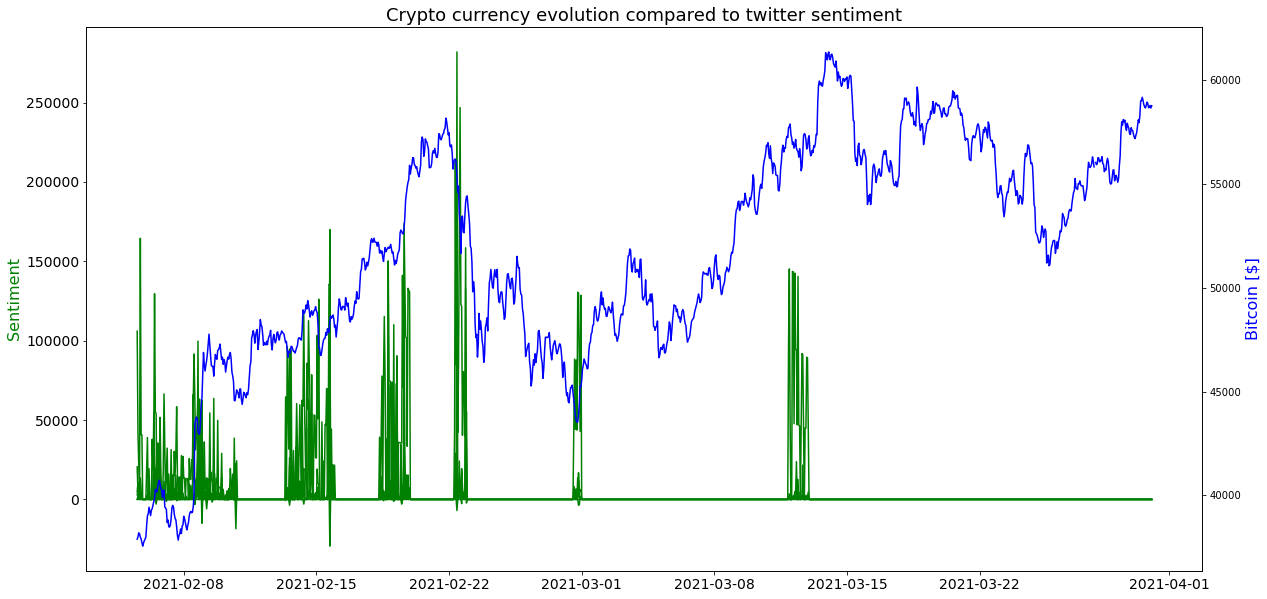

In [14]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(btc_grouped.index, btc_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

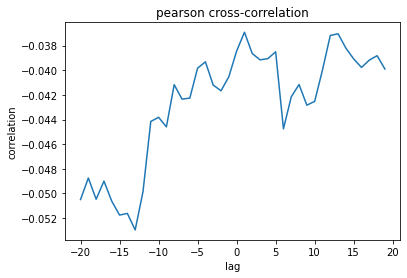

In [15]:
xcov = [crosscorr(tweets_grouped, btc_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

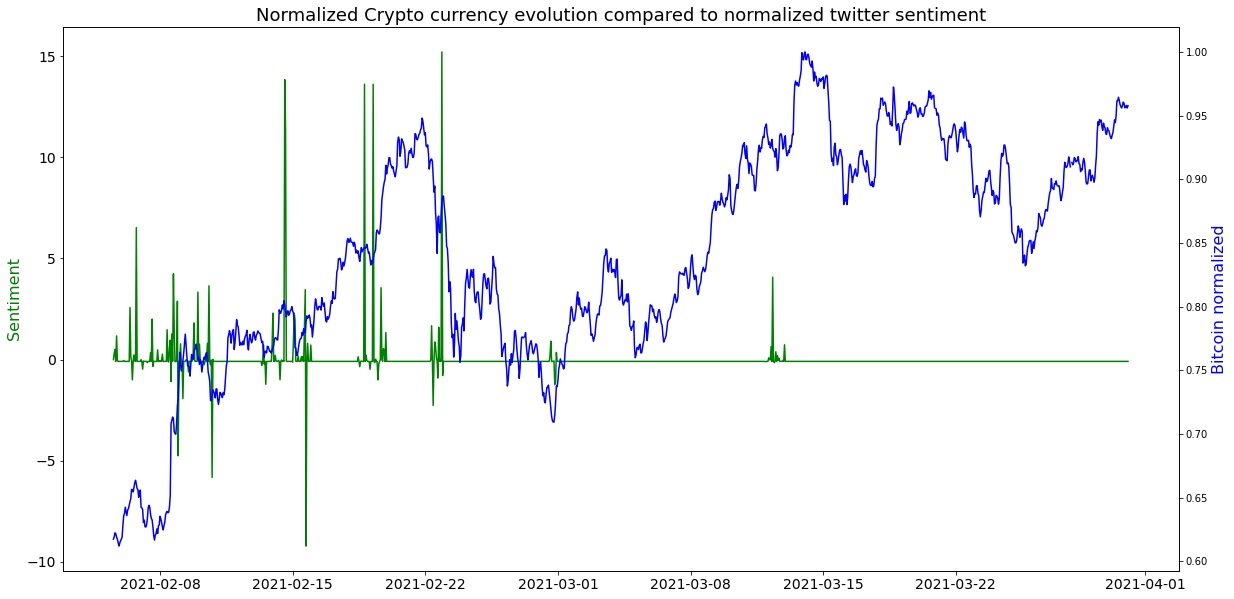

In [16]:
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
btc_grouped_scaled = btc_grouped / max(btc_grouped.max(), abs(btc_grouped.min()))


fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(btc_grouped.index, btc_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

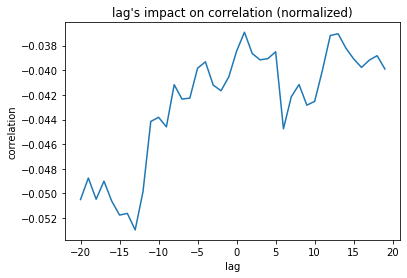

In [17]:
xcov = [crosscorr(tweets_grouped, btc_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


### Derivative of BTC price and sentiment

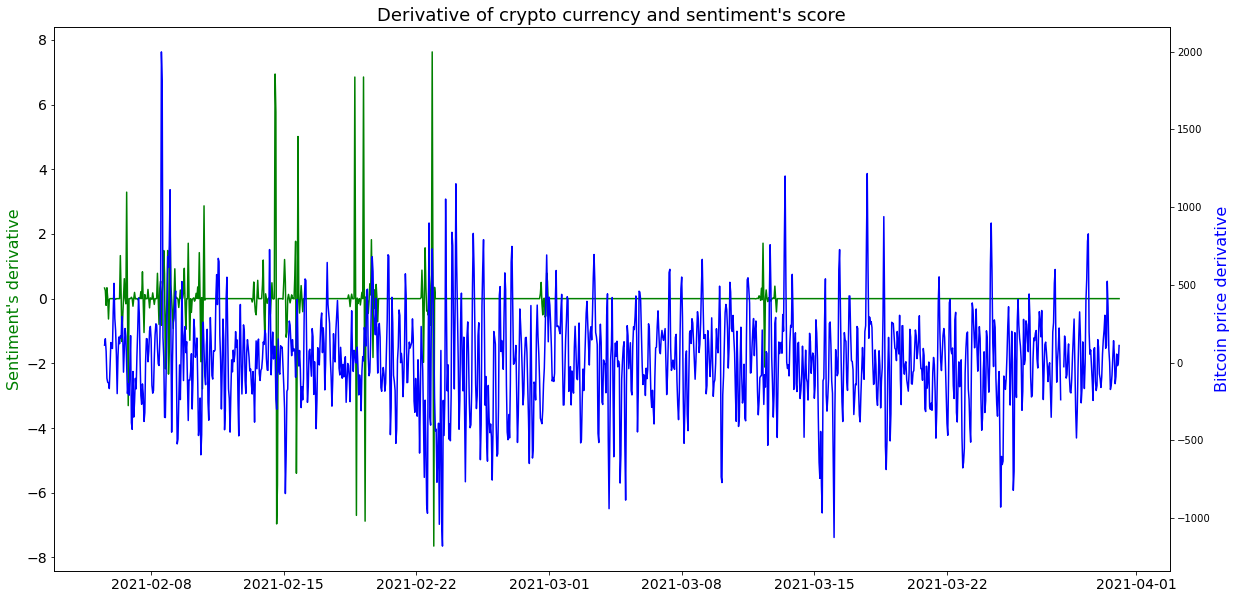

In [18]:
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
btc_grouped_derivative = pd.Series(np.gradient(btc_grouped.values), btc_grouped.index, name='slope')

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(btc_grouped_derivative.index, btc_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

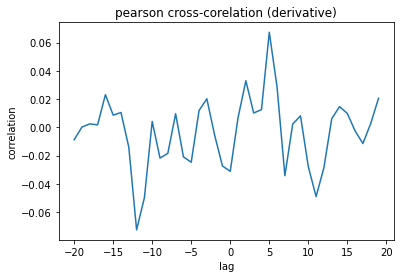

In [19]:
xcov = [crosscorr(tweets_grouped, btc_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()